# Notebook relevant version changes

<div style="border-radius:10px; border: #babab5 solid; padding: 15px; background-color: #e6f9ff; font-size:100%;">
   
* V11 (CV 1-fold: 90.76 / LB: 97.66)
    * model by 

# Global Params

In [351]:
import torch
import os

seed = 42

# GPU or CPU use for model
if torch.cuda.is_available():
    device = 'gpu'
else:
    device = 'cpu'

# For kaggle environment
if os.environ.get("KAGGLE_DATA_PROXY_TOKEN") != None:
    IS_LOCAL = False
    IS_DEBUG = False
    BASE_INPUT_PATH = "/kaggle/input"
    BASE_OUTPUT_PATH = "/kaggle/working"

    STOPPING_ROUNDS = 100 # early_stopping用コールバック関数
    NUM_BOOST_ROUND = 100 # 計算回数
    N_SPLITS = 5 # 交差検証の分割数
    USE_CUSTOME_FOLD = False # 自作foldを使用するかどうか
    MODEL_NUM = 3 # モデルの数, N_SPLITS以下である必要がある
    GROUP_KEYS = ["is_consumption", "product_type"] # group_keysの指定, country, product_type, is_business, is_consumptionが候補

    """
    LGB_PARAMS = {
        "objective": "mae",
        "n_estimators": 3000,
        "num_leaves": 256,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
        "learning_rate": 0.015, #0.00871,
        'max_depth': 11,
        "n_jobs": 4,
        "verbosity": -1,
        "importance_type": "gain",
        "device": device,
    }
    """
    LGB_PARAMS = {
        "objective": "mae",
        "n_estimators": 2,
        "num_leaves": 2,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
        "learning_rate": 0.15, #0.00871,
        'max_depth': 11,
        "n_jobs": 4,
        "verbosity": -1,
        "importance_type": "gain",
        "device": device,
    }
   
# For local environment
else:
    IS_LOCAL = True
    IS_DEBUG = True
    BASE_INPUT_PATH = "../kaggle/input"
    BASE_OUTPUT_PATH = "../kaggle/working"


    STOPPING_ROUNDS = 50 # early_stopping用コールバック関数
    NUM_BOOST_ROUND = 50 # 計算回数
    N_SPLITS = 3 # 交差検証の分割数
    USE_CUSTOME_FOLD = False 
    MODEL_NUM = 2 # モデルの数, N_SPLITS以下である必要がある
    GROUP_KEYS = ["is_consumption", "product_type"] # group_keysの指定, country, product_type, is_business, is_consumptionが候補
    
    LGB_PARAMS = {
        "objective": "mae",
        "n_estimators": 2,
        "num_leaves": 2,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
        "learning_rate": 0.15, #0.00871,
        'max_depth': 11,
        "n_jobs": 4,
        "verbosity": -1,
        "importance_type": "gain",
        "device": device,
    }
print("device: ", device)
print("IS_LOCAL: ", IS_LOCAL)
print("IS_DEBUG: ", IS_DEBUG)
print("BASE_INPUT_PATH: ", BASE_INPUT_PATH)
print("BASE_OUTPUT_PATH: ", BASE_OUTPUT_PATH)
print("STOPPING_ROUNDS: ", STOPPING_ROUNDS)
print("NUM_BOOST_ROUND: ", NUM_BOOST_ROUND)
print("N_SPLITS: ", N_SPLITS)
print("USE_CUSTOME_FOLD: ", USE_CUSTOME_FOLD)
print("MODEL_NUM: ", MODEL_NUM)
print("GROUP_KEYS: ", GROUP_KEYS)
print("LGB_PARAMS: ", LGB_PARAMS)

device:  cpu
IS_LOCAL:  True
IS_DEBUG:  True
BASE_INPUT_PATH:  ../kaggle/input
BASE_OUTPUT_PATH:  ../kaggle/working
STOPPING_ROUNDS:  50
NUM_BOOST_ROUND:  50
N_SPLITS:  3
USE_CUSTOME_FOLD:  False
MODEL_NUM:  2
GROUP_KEYS:  ['is_consumption', 'product_type']
LGB_PARAMS:  {'objective': 'mae', 'n_estimators': 2, 'num_leaves': 2, 'subsample': 0.6, 'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 11, 'n_jobs': 4, 'verbosity': -1, 'importance_type': 'gain', 'device': 'cpu'}


# Install & imports

In [352]:
from pathlib import Path
import os
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import gc  # Garbage collection for memory management
import time  # Time-related functions
import warnings  # Handling warnings
from itertools import combinations  # For creating combinations of elements
from warnings import simplefilter  # Simplifying warning handling
import joblib  # For saving and loading models
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
from sklearn.metrics import mean_absolute_error  # Metric for evaluation
from sklearn.model_selection import KFold, TimeSeriesSplit  # Cross-validation techniques
from concurrent.futures import ThreadPoolExecutor
from numba import njit, prange  # Compiling Python code for performance
from dataclasses import dataclass
import polars as pl
from gc import collect;
from psutil import Process;
from os import system, getpid, walk;

# Disable warnings to keep the code clean
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Functions

In [353]:
'''
An unlocked version of the timeseries API intended for testing alternate inputs.
Mirrors the production timeseries API in the crucial respects, but won't be as fast.

ONLY works afer the first three variables in MockAPI.__init__ are populated.
'''

from typing import Sequence, Tuple

import pandas as pd


class MockApi:
    def __init__(self):
        '''
        YOU MUST UPDATE THE FIRST THREE LINES of this method.
        They've been intentionally left in an invalid state.

        Variables to set:
            input_paths: a list of two or more paths to the csv files to be served
            group_id_column: the column that identifies which groups of rows the API should serve.
                A call to iter_test serves all rows of all dataframes with the current group ID value.
            export_group_id_column: if true, the dataframes iter_test serves will include the group_id_column values.
        '''
             
        self.fpath=f"{BASE_INPUT_PATH}/predict-energy-behavior-of-prosumers/example_test_files"
        self.input_paths: Sequence[str] = [self.fpath + '/test.csv', self.fpath + '/revealed_targets.csv', 
                                           self.fpath + '/client.csv', 
                                           self.fpath + '/historical_weather.csv', self.fpath + '/forecast_weather.csv', 
                                           self.fpath + '/electricity_prices.csv', self.fpath + '/gas_prices.csv',
                                           self.fpath + '/sample_submission.csv']
        self.group_id_column: str = "data_block_id"
        self.export_group_id_column: bool = True
        # iter_test is only designed to support at least two dataframes, such as test and sample_submission
        assert len(self.input_paths) >= 2

        self._status = 'initialized'
        self.predictions = []

    def iter_test(self) -> Tuple[pd.DataFrame]:
        '''
        Loads all of the dataframes specified in self.input_paths,
        then yields all rows in those dataframes that equal the current self.group_id_column value.
        '''
        if self._status != 'initialized':

            raise Exception('WARNING: the real API can only iterate over `iter_test()` once.')

        dataframes = []
        for pth in self.input_paths:
            dataframes.append(pd.read_csv(pth, low_memory=False))
        group_order = dataframes[0][self.group_id_column].drop_duplicates().tolist()
        dataframes = [df.set_index(self.group_id_column) for df in dataframes]

        for group_id in group_order:
            self._status = 'prediction_needed'
            current_data = []
            for df in dataframes:
                cur_df = df.loc[group_id].copy()
                # returning single line dataframes from df.loc requires special handling
                if not isinstance(cur_df, pd.DataFrame):
                    cur_df = pd.DataFrame({a: b for a, b in zip(cur_df.index.values, cur_df.values)}, index=[group_id])
                    cur_df.index.name = self.group_id_column
                cur_df = cur_df.reset_index(drop=not(self.export_group_id_column))
                current_data.append(cur_df)
            yield tuple(current_data)

            while self._status != 'prediction_received':
                print('You must call `predict()` successfully before you can continue with `iter_test()`', flush=True)
                yield None

        with open('submission.csv', 'w') as f_open:
            pd.concat(self.predictions).to_csv(f_open, index=False)
        self._status = 'finished'

    def predict(self, user_predictions: pd.DataFrame):
        '''
        Accepts and stores the user's predictions and unlocks iter_test once that is done
        '''
        if self._status == 'finished':
            raise Exception('You have already made predictions for the full test set.')
        if self._status != 'prediction_needed':
            raise Exception('You must get the next test sample from `iter_test()` first.')
        if not isinstance(user_predictions, pd.DataFrame):
            raise Exception('You must provide a DataFrame.')

        self.predictions.append(user_predictions)
        self._status = 'prediction_received'


def make_env():
    return MockApi()

In [354]:
# DataPath
@dataclass(frozen=True)
class DataPath:
    base_path: str
    train: str = None
    client: str = None
    gas_prices: str = None
    electricity_prices: str = None
    forecast_weather: str = None
    historical_weather: str = None
    weather_station_to_county_mapping: str = None
    county_lon_lats: str = None
    county_id_to_name_map: str = None

    def __post_init__(self):
        predict_energy_behavior_of_prosumers_path = os.path.join(self.base_path, "predict-energy-behavior-of-prosumers")
        fabiendaniels_mapping_locations_and_county_codes_path = os.path.join(self.base_path, "fabiendaniels-mapping-locations-and-county-codes")

        object.__setattr__(self, 'train', os.path.join(predict_energy_behavior_of_prosumers_path, "train.csv"))
        object.__setattr__(self, 'client', os.path.join(predict_energy_behavior_of_prosumers_path, "client.csv"))
        object.__setattr__(self, 'gas_prices', os.path.join(predict_energy_behavior_of_prosumers_path, "gas_prices.csv"))
        object.__setattr__(self, 'electricity_prices', os.path.join(predict_energy_behavior_of_prosumers_path, "electricity_prices.csv"))
        object.__setattr__(self, 'forecast_weather', os.path.join(predict_energy_behavior_of_prosumers_path, "forecast_weather.csv"))
        object.__setattr__(self, 'historical_weather', os.path.join(predict_energy_behavior_of_prosumers_path, "historical_weather.csv"))
        object.__setattr__(self, 'weather_station_to_county_mapping', os.path.join(predict_energy_behavior_of_prosumers_path, "weather_station_to_county_mapping.csv"))
        object.__setattr__(self, 'county_lon_lats', os.path.join(fabiendaniels_mapping_locations_and_county_codes_path, "county_lon_lats.csv"))
        object.__setattr__(self, 'county_id_to_name_map', os.path.join(predict_energy_behavior_of_prosumers_path, "county_id_to_name_map.json"))

In [355]:
from colorama import Fore, Style, init;

def PrintMemUsage():
    """
    This function defines the memory usage across the kernel. 
    Source-
    https://stackoverflow.com/questions/61366458/how-to-find-memory-usage-of-kaggle-notebook
    """;
    
    pid = getpid();
    py = Process(pid);
    memory_use = py.memory_info()[0] / 2. ** 30;
    print(f"RAM memory GB usage = {memory_use :.4}");

def get_pl_df_size(df: pl.DataFrame, unit: str = "gb"):
    # unit = {‘b’, ‘kb’, ‘mb’, ‘gb’, ‘tb’}
    mem_uage = df.estimated_size(unit)
    return mem_uage

# Helper functions
def display_df(df, name, rows = 5):
    '''Display df shape and rows'''
    PrintColor(text = f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns. \n ===>  row:')
    display(df.head(rows))

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    '''Prints color outputs using colorama of a text string'''
    print(style + color + text + Style.RESET_ALL);

    
def GetMemUsage():
    """
    This function defines the memory usage across the kernel. 
    Source-
    https://stackoverflow.com/questions/61366458/how-to-find-memory-usage-of-kaggle-notebook
    """;
    
    pid = getpid();
    py = Process(pid);
    memory_use = py.memory_info()[0] / 2. ** 30;
    return f"RAM memory GB usage = {memory_use :.4}";

# 🧹 Function to reduce memory usage of a Pandas DataFrame
def reduce_mem_usage(df, name: str, show_optimization: bool = False):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    
    # 📏 Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # 🔄 Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    if show_optimization:
        print(f"Memory usage of {name} is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    # 🔄 Return the DataFrame with optimized memory usage

    start_mem = df.memory_usage().sum() / 1024**2
    return df

# Load data


In [356]:
%%time

import json

data_path = DataPath(BASE_INPUT_PATH)
print("data_path", data_path)

train = pd.read_csv(data_path.train, parse_dates=True)
client = pd.read_csv(data_path.client, parse_dates=True)
gas = pd.read_csv(data_path.gas_prices, parse_dates=True)
electricity = pd.read_csv(data_path.electricity_prices, parse_dates=True)
forecast_weather = pd.read_csv(data_path.forecast_weather, parse_dates=True)
historical_weather = pd.read_csv(data_path.historical_weather, parse_dates=True)
weather_station_to_county_mapping = pd.read_csv(data_path.weather_station_to_county_mapping, parse_dates=True)
location = pd.read_csv(data_path.county_lon_lats, parse_dates=True).drop(columns = ["Unnamed: 0"])

# See county codes
with open(data_path.county_id_to_name_map) as f:
    county_codes = json.load(f)
pd.DataFrame(county_codes, index=[0])

"""
train = reduce_mem_usage(train, "train")
client = reduce_mem_usage(client, "client")
gas = reduce_mem_usage(gas, "gas")
electricity = reduce_mem_usage(electricity, "electricity")
forecast_weather = reduce_mem_usage(forecast_weather, "forecast_weather")
historical_weather = reduce_mem_usage(historical_weather, "historical_weather")
weather_station_to_county_mapping = reduce_mem_usage(weather_station_to_county_mapping, "weather_station_to_county_mapping")
location = reduce_mem_usage(location, "location")
"""

PrintMemUsage()

data_path DataPath(base_path='../kaggle/input', train='../kaggle/input/predict-energy-behavior-of-prosumers/train.csv', client='../kaggle/input/predict-energy-behavior-of-prosumers/client.csv', gas_prices='../kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv', electricity_prices='../kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv', forecast_weather='../kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv', historical_weather='../kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv', weather_station_to_county_mapping='../kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv', county_lon_lats='../kaggle/input/fabiendaniels-mapping-locations-and-county-codes/county_lon_lats.csv', county_id_to_name_map='../kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json')


FileNotFoundError: [Errno 2] No such file or directory: '../kaggle/input/predict-energy-behavior-of-prosumers/train.csv'

In [357]:
col_target = "target"
col_data = train.columns.drop(col_target)
col_client = client.columns
col_gas = gas.columns
col_electricity = electricity.columns
col_forecast_weather = forecast_weather.columns
col_historical_weather = historical_weather.columns
col_weather_station_to_county_mapping = weather_station_to_county_mapping.columns
col_location = location.columns

NameError: name 'train' is not defined

# Generate Features

In [ ]:
class FeatureProcessorClass():
    def __init__(self):         
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def create_data_features(self, data):
        '''📊Create features for main data (test or train) set📊'''
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week.astype('int')
        data['hour'] = data['datetime'].dt.hour
        
        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        '''💼 Create client features 💼'''
        # Modify column names - specify suffix
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client
    
    def create_historical_weather_features(self, historical_weather):
        '''⌛🌤️ Create historical weather features 🌤️⌛'''
        
        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        
        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        
        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return historical_weather
    
    def create_forecast_weather_features(self, forecast_weather):
        '''🔮🌤️ Create forecast weather features 🌤️🔮'''
        
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )
        
        # To datetime
        forecast_weather['datetime'] = (pd.to_datetime(forecast_weather['datetime'])
                                        .dt
                                        .tz_localize(None)
                                       )

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)
        
        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)     
        return forecast_weather

    def create_electricity_features(self, electricity):
        '''⚡ Create electricity prices features ⚡'''
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        
        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )             
        return electricity

    def create_gas_features(self, gas):
        '''⛽ Create gas prices features ⛽'''
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        
        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas, 
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )
        return gas
    
    def convert_types(self, df):
        """_summary_
        Args:
            df (_type_): _description_
        """
        for col in df.columns:
            dtype = df[col].dtype
            if dtype == "object":
                df[col] = df[col].astype("category")
            elif dtype == "bool":
                df[col] = df[col].astype("bool")
            elif dtype == "float64":
                df[col] = df[col].astype("float32")
            elif dtype == "int64":
                df[col] = df[col].astype("int32")
        return df
    
    def check_missing_values(self, df):
        for category_col in self.category_columns:
            if df[category_col].isnull().sum() > 0:
                raise Exception(f"Missing values in {category_col}: {df[category_col].isnull().sum()}")
    
    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)
        
        # 🔗 Merge all datasets into one df 🔗
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        # Change columns to categorical
        self.check_missing_values(df)
        df = self.convert_types(df)
        df[self.category_columns] = df[self.category_columns].astype('int32').astype('category')
        return df

In [ ]:
def create_revealed_targets_train(data, N_day_lags):
    '''🎯 Create past revealed_targets for train set based on number of day lags N_day_lags 🎯 '''    
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # Create revealed targets for all day lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [ ]:
%%time

N_day_lags = 15 # Specify how many days we want to go back (at least 2)

FeatureProcessor = FeatureProcessorClass()

train_with_features = FeatureProcessor(data = train.copy(),
                        client = client.copy(),
                        historical_weather = historical_weather.copy(),
                        forecast_weather = forecast_weather.copy(),
                        electricity = electricity.copy(),
                        gas = gas.copy())

#train_with_features = reduce_mem_usage(train_with_features, "train_with_features")
train_with_features = create_revealed_targets_train(train_with_features.copy(), 
                                  N_day_lags = N_day_lags)
train_with_features.head()

del train, client, historical_weather, forecast_weather, electricity, gas
collect()
GetMemUsage()

CPU times: user 15.7 s, sys: 8.74 s, total: 24.5 s
Wall time: 25.7 s


'RAM memory GB usage = 1.393'

In [ ]:
# Remove columns for features
no_features = ['date', 
                'latitude', 
                'longitude', 
                'data_block_id', 
                'row_id',
                'hours_ahead',
                'hour_h',
                'target'
               ]

remove_columns = [col for col in train_with_features.columns for no_feature in no_features if no_feature in col]
features = [col for col in train_with_features.columns if col not in remove_columns]
PrintColor(f'There are {len(features)} features: {features}')

There are 45 features: ['county', 'is_business', 'product_type', 'is_consumption', 'prediction_unit_id', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean', 'cloudcover_mid_f_mean', 'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean', 'surface_solar_radiation_downwards_f_mean', 'snowfall_f_mean', 'total_precipitation_f_mean', 'euros_per_mwh_electricity', 'lowest_price_per_mwh_gas', 'highest_

In [ ]:
train_with_features[features].dtypes

county                                      category
is_business                                 category
product_type                                category
is_consumption                              category
prediction_unit_id                             int64
year                                           int32
quarter                                        int32
month                                          int32
week                                           int64
hour                                           int32
day_of_year                                    int32
day_of_month                                   int32
day_of_week                                    int32
eic_count_client                             float64
installed_capacity_client                    float64
temperature_h_mean                           float64
dewpoint_h_mean                              float64
rain_h_mean                                  float64
snowfall_h_mean                              f

In [ ]:
def filter_data_with_feature(df, target_country, target_product_type, target_is_business, target_is_consumption, target_data_block_id=None):
    '''Filter data with given target values'''
    df = df[(df['county'] == target_country) &
            (df['product_type'] == target_product_type) &
            (df['is_business'] == target_is_business) &
            (df['is_consumption'] == target_is_consumption)]
    if target_data_block_id:
        df = df[df['data_block_id'] == target_data_block_id]
    return df
if IS_DEBUG:
    target_country = 0
    target_product_type = 0
    target_data_block_id = 10
    target_is_business = 1
    target_is_consumption = 1

    target_train_with_features = filter_data_with_feature(train_with_features, target_country, target_product_type, target_is_business, target_is_consumption, target_data_block_id)
    display_df(target_train_with_features, "target_train_with_features", 5)

target_train_with_features data has 24 rows and 71 columns. 
 ===>  row:


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,target_6_days_ago,target_7_days_ago,target_8_days_ago,target_9_days_ago,target_10_days_ago,target_11_days_ago,target_12_days_ago,target_13_days_ago,target_14_days_ago,target_15_days_ago
29287,0,1,0,70.7,1,2021-09-11 00:00:00,10,29287,3,2021-09-11,...,73.7,75.8,64.1,75.8,59.0,NaN,NaN,NaN,NaN,NaN
29409,0,1,0,58.2,1,2021-09-11 01:00:00,10,29409,3,2021-09-11,...,74.9,74.1,57.0,76.3,61.6,NaN,NaN,NaN,NaN,NaN
29531,0,1,0,55.8,1,2021-09-11 02:00:00,10,29531,3,2021-09-11,...,75.7,74.4,56.8,74.0,63.1,NaN,NaN,NaN,NaN,NaN
29653,0,1,0,57.0,1,2021-09-11 03:00:00,10,29653,3,2021-09-11,...,78.9,77.7,59.2,77.9,64.0,NaN,NaN,NaN,NaN,NaN
29775,0,1,0,57.0,1,2021-09-11 04:00:00,10,29775,3,2021-09-11,...,77.5,77.5,63.3,76.5,60.5,NaN,NaN,NaN,NaN,NaN


# Train model

In [ ]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import gc
import os
from sklearn.model_selection import KFold
import numpy as np
from dataclasses import dataclass
import sys
import shutil
import lightgbm as lgb

from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

@dataclass
class Model:
    key: str
    booster: lgb.Booster
    train_len: int
    val_len: int
    fold: int
    features: list
    feature_importance: pd.DataFrame
    score: float
    best_iteration: int
    train_time: float = None
    weight: float = None
    mem_usage: float = None
    is_latest: bool = False
    description: str = None

def group_key_value_mapper(value, group_keys=GROUP_KEYS):
    return dict(zip(group_keys, value))

class LighBGMTrainer:
    def train_model(self, train_x, train_y, val_x, val_y, lgb_params=LGB_PARAMS, num_boost_round=NUM_BOOST_ROUND, stopping_rounds=STOPPING_ROUNDS):
        """_summary_

        Args:
            train_x (_type_): _description_
            train_y (_type_): _description_
            val_x (_type_): _description_
            val_y (_type_): _description_
            lgb_params (_type_, optional): _description_. Defaults to LGB_PARAMS.
            num_boost_round (_type_, optional): _description_. Defaults to NUM_BOOST_ROUND.
            stopping_rounds (_type_, optional): _description_. Defaults to STOPPING_ROUNDS.

        Returns:
            _type_: _description_
        """
        trains = lgb.Dataset(train_x, train_y)
        valids = lgb.Dataset(val_x, val_y, reference=trains)
        verbose_eval = -1

        #print(f"lgb_params: {lgb_params}")
        #print(f"stopping_rounds: {num_boost_round}, num_boost_round: {stopping_rounds}")
        #print(f"train_x: {train_x.shape}, train_y: {train_y.shape}, val_x: {val_x.shape}, val_y: {val_y.shape}")
        
        booster = lgb.train(
            lgb_params,
            trains,
            valid_sets=valids,
            num_boost_round=num_boost_round,
            keep_training_booster=True,
            callbacks=[
                    lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=True),
                    lgb.log_evaluation(verbose_eval)
            ]
        )

        del trains, valids
        return booster

    def cross_train(self, df, key, features, valid=col_target, n_splits=N_SPLITS, use_custome_fold=USE_CUSTOME_FOLD, model_num=MODEL_NUM):
        """_summary_

        Args:
            df (_type_): _description_
            key (_type_): _description_
            features (_type_): _description_
            valid (_type_, optional): _description_. Defaults to col_target.
            n_splits (_type_, optional): _description_. Defaults to N_SPLITS.
            use_custome_fold (_type_, optional): _description_. Defaults to USE_CUSTOME_FOLD.
            model_num (_type_, optional): _description_. Defaults to MODEL_NUM.
        """
        def __train(fold, X_train, y_train, X_valid, y_valid, description=None):
            now_time = time.time()
            booster = self.train_model(X_train, y_train, X_valid, y_valid)
            train_time = time.time() - now_time
            print(f"train_time: {train_time:.2f} [sec]")

            now_time = time.time()
            y_valid_pred = booster.predict(X_valid)
            score = mean_absolute_error(y_valid, y_valid_pred)
            valid_time = time.time() - now_time
            print(f"valid_time: {valid_time:.2f} [sec]")

            mem_usage = sys.getsizeof(booster) / (1024 * 1024) # MB

            model = Model(
                key=key,
                booster=booster,
                train_len=len(X_train),
                val_len=len(X_valid),
                fold=fold,
                features=  features,
                feature_importance=booster.feature_importance(importance_type="gain"),
                score=score,
                best_iteration=booster.best_iteration,
                train_time=train_time,
                weight=None,
                mem_usage=mem_usage,
                is_latest=True,
                description=description
            )
  
            del X_train, X_valid, y_train, y_valid
            gc.collect()
            print(GetMemUsage())
            return model

        models = []
        description = group_key_value_mapper(key)
        print(f"---- Cross train {description} start ----")

        if use_custome_fold:
            pass # TODO

        else:
            print("NOT use_custome_fold")
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
            df.reset_index(drop=True, inplace=True)
            
            for fold, (train_indices, valid_indices) in enumerate(kf.split(df)):
                print(f"- Train {description}: {fold} start -")

                print(f"train_indices: {train_indices}, valid_indices: {valid_indices}")
                X_train, X_valid = df[features].iloc[train_indices], df[features].iloc[valid_indices]
                y_train, y_valid = df[valid].loc[train_indices], df[valid].loc[valid_indices]
                model = __train(fold, X_train, y_train, X_valid, y_valid, description)
                models.append(model)
                print(f"- Train end -")

        models.sort(key=lambda x: x.score)
        [print(f"fold: {model.fold}, score: {model.score}") for model in models]
        models = models[:model_num]
        print(f"---- Cross train end, model len {len(models)} ----")
        return models
    
    def grouped_cross_train(self, df, group_keys, features, valid=col_target, n_splits=N_SPLITS, use_custome_fold=USE_CUSTOME_FOLD, model_num=MODEL_NUM):
        """_summary_

        Args:
            df (_type_): _description_
            group_keys (_type_): _description_
            features (_type_): _description_
            valid (_type_, optional): _description_. Defaults to col_target.
            n_splits (_type_, optional): _description_. Defaults to N_SPLITS.
            use_custome_fold (_type_, optional): _description_. Defaults to USE_CUSTOME_FOLD.
            model_num (_type_, optional): _description_. Defaults to MODEL_NUM.
        """
        print("grouped_cross_train start")
        df = df.copy()
        df = df[df[col_target].notnull()] # remove null target
        df.reset_index(drop=True, inplace=True)
        key_models = df.groupby(group_keys).apply(lambda x: self.cross_train(df=x, key=x.name, features=features, valid=valid, n_splits=n_splits, use_custome_fold=use_custome_fold, model_num=model_num))
        return key_models

In [ ]:
%%time

key_models = LighBGMTrainer().grouped_cross_train(train_with_features, GROUP_KEYS, features)
key_models

grouped_cross_train start
---- Cross train {'is_consumption': 0, 'product_type': 0} start ----
NOT use_custome_fold
- Train {'is_consumption': 0, 'product_type': 0}: 0 start -
train_indices: [    0     1     2 ... 85245 85247 85248], valid_indices: [    4     6     7 ... 85244 85246 85249]
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's l1: 34.3355
train_time: 0.13 [sec]
valid_time: 0.01 [sec]
RAM memory GB usage = 3.321
- Train end -
- Train {'is_consumption': 0, 'product_type': 0}: 1 start -
train_indices: [    2     4     5 ... 85247 85248 85249], valid_indices: [    0     1     3 ... 85238 85240 85242]
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's l1: 34.9002
train_time: 0.13 [sec]
valid_time: 0.01 [sec]
RAM memory GB usage = 3.357
- Train end -
- Train {'is_consumption': 0, 'product_type': 0}: 2 start -
train_indices: [    0     1 

is_consumption  product_type
0               0               [Model(key=(0, 0), booster=<lightgbm.basic.Boo...
                1               [Model(key=(0, 1), booster=<lightgbm.basic.Boo...
                2               [Model(key=(0, 2), booster=<lightgbm.basic.Boo...
                3               [Model(key=(0, 3), booster=<lightgbm.basic.Boo...
1               0               [Model(key=(1, 0), booster=<lightgbm.basic.Boo...
                1               [Model(key=(1, 1), booster=<lightgbm.basic.Boo...
                2               [Model(key=(1, 2), booster=<lightgbm.basic.Boo...
                3               [Model(key=(1, 3), booster=<lightgbm.basic.Boo...
dtype: object

In [ ]:
model_dict = key_models.to_dict()
for key, models in model_dict.items():
    print(f"key: {models[0].description}, model len: {len(models)}")

key: {'is_consumption': 0, 'product_type': 0}, model len: 2
key: {'is_consumption': 0, 'product_type': 1}, model len: 2
key: {'is_consumption': 0, 'product_type': 2}, model len: 2
key: {'is_consumption': 0, 'product_type': 3}, model len: 2
key: {'is_consumption': 1, 'product_type': 0}, model len: 2
key: {'is_consumption': 1, 'product_type': 1}, model len: 2
key: {'is_consumption': 1, 'product_type': 2}, model len: 2
key: {'is_consumption': 1, 'product_type': 3}, model len: 2


# Show train results

In [ ]:
# Show results

for key, models in model_dict.items():
    print(f"Key: {key}, model len: {len(models)}")
    data = []
    for model in models:
        data.append({"fold": model.fold, "score": model.score, "train_len": model.train_len , "valid_len": model.val_len, "best_iteration": model.best_iteration, "train_time": model.train_time})

    df_model = pd.DataFrame(data)
    print(df_model.describe())


Key: (0, 0), model len: 2
           fold      score  train_len  valid_len  best_iteration  train_time
count  2.000000   2.000000        2.0        2.0             2.0    2.000000
mean   0.500000  34.617892    56833.0    28417.0             2.0    0.129512
std    0.707107   0.399301        0.0        0.0             0.0    0.003724
min    0.000000  34.335544    56833.0    28417.0             2.0    0.126879
25%    0.250000  34.476718    56833.0    28417.0             2.0    0.128195
50%    0.500000  34.617892    56833.0    28417.0             2.0    0.129512
75%    0.750000  34.759067    56833.0    28417.0             2.0    0.130828
max    1.000000  34.900241    56833.0    28417.0             2.0    0.132145
Key: (0, 1), model len: 2
           fold      score  train_len  valid_len  best_iteration  train_time
count  2.000000   2.000000        2.0        2.0             2.0    2.000000
mean   1.500000  38.345408   260476.0   130238.0             2.0    0.460786
std    0.707107   0.1646

           fold     score  train_len  valid_len  best_iteration  train_time
count  2.000000  2.000000        2.0        2.0             2.0    2.000000
mean   1.500000  5.153456    49139.0    24569.0             2.0    0.099872
std    0.707107  0.055996        0.0        0.0             0.0    0.001071
min    1.000000  5.113860    49139.0    24569.0             2.0    0.099115
25%    1.250000  5.133658    49139.0    24569.0             2.0    0.099494
50%    1.500000  5.153456    49139.0    24569.0             2.0    0.099872
75%    1.750000  5.173253    49139.0    24569.0             2.0    0.100251
max    2.000000  5.193051    49139.0    24569.0             2.0    0.100630
Key: (0, 3), model len: 2
           fold       score  train_len  valid_len  best_iteration  train_time
count  2.000000    2.000000        2.0        2.0             2.0    2.000000
mean   1.500000  141.846356   306160.0   153080.0             2.0    0.470532
std    0.707107    2.705547        0.0        0.0       

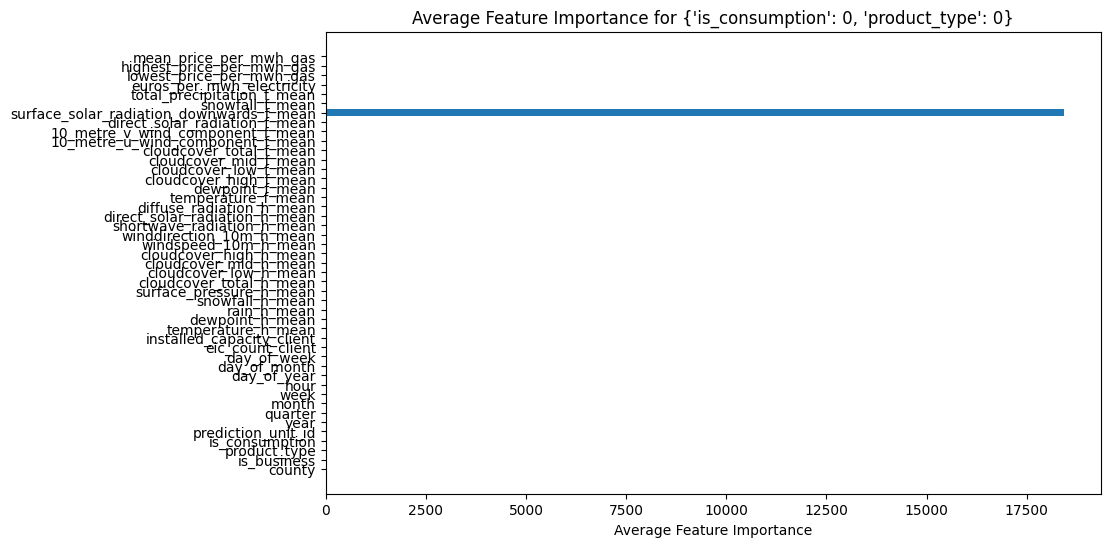

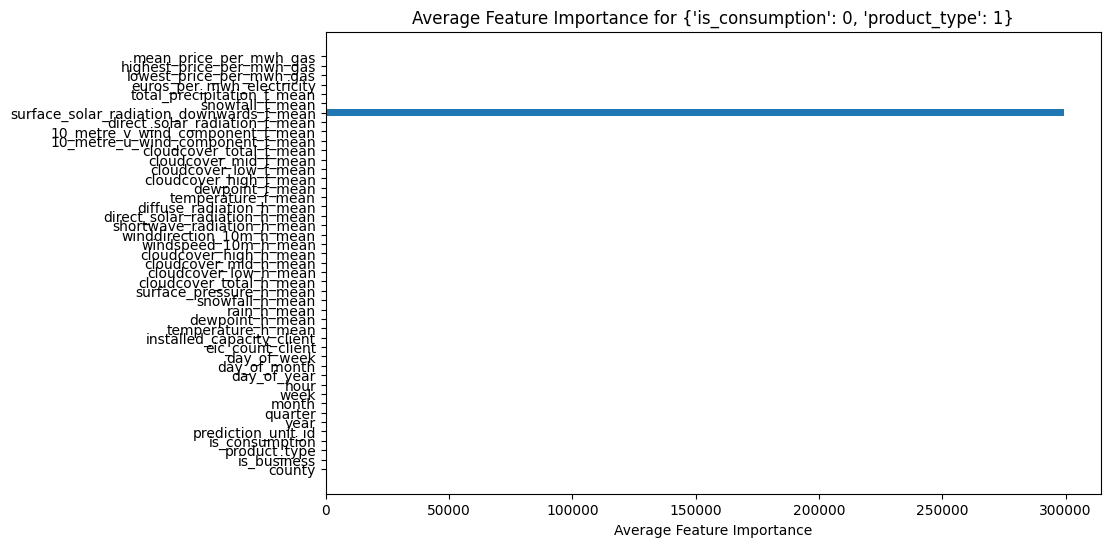

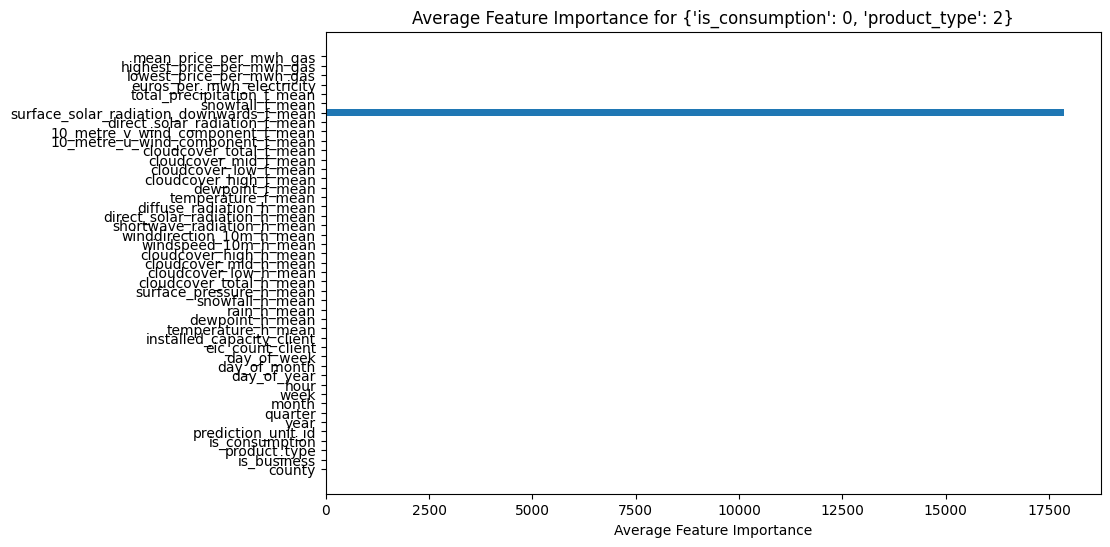

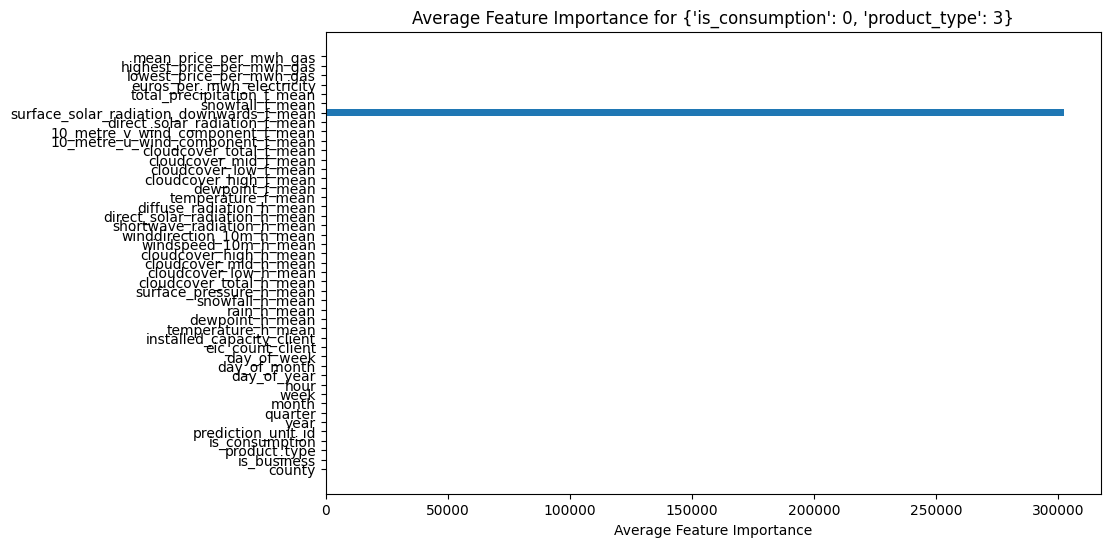

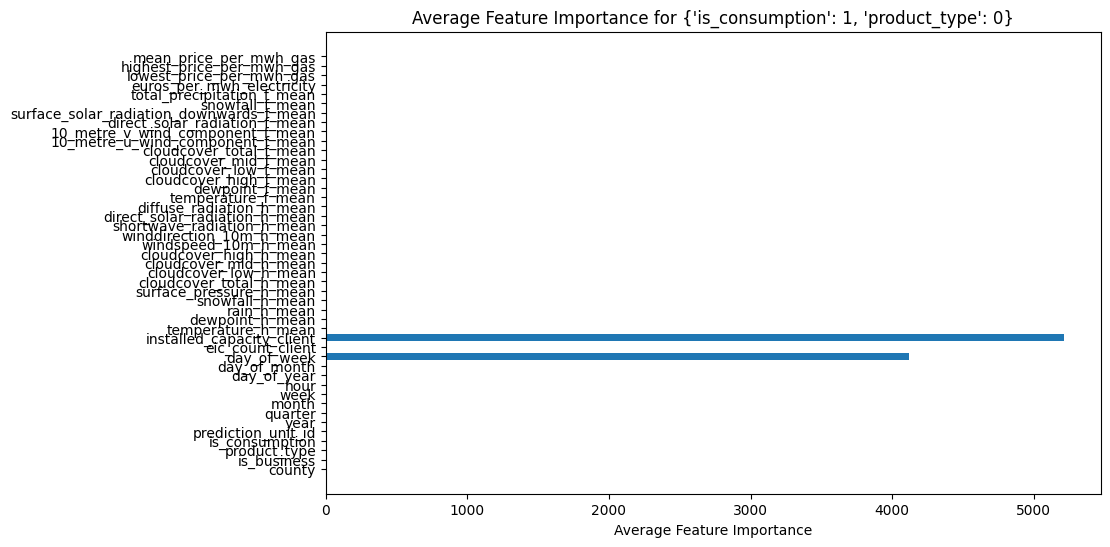

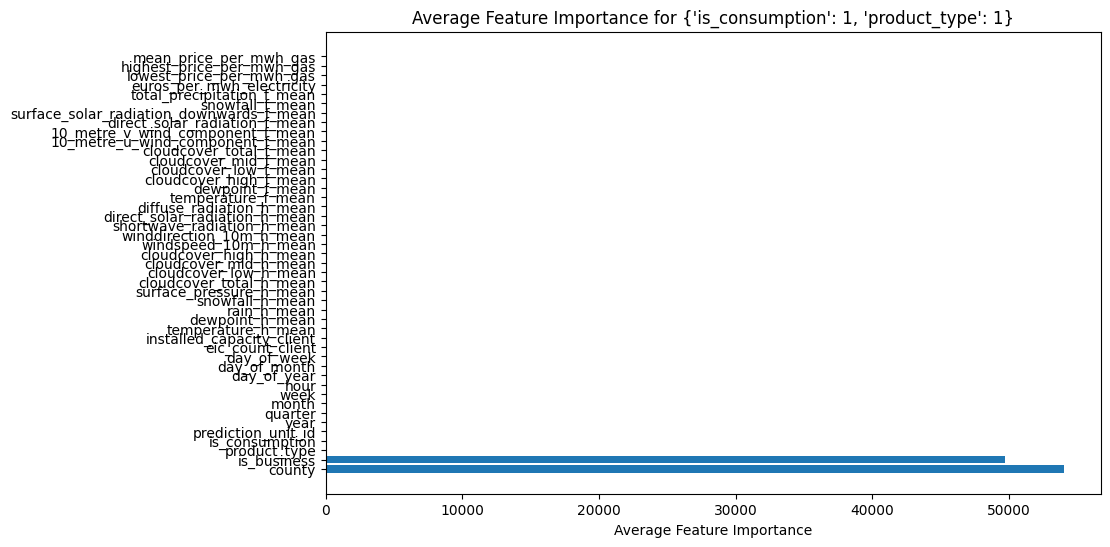

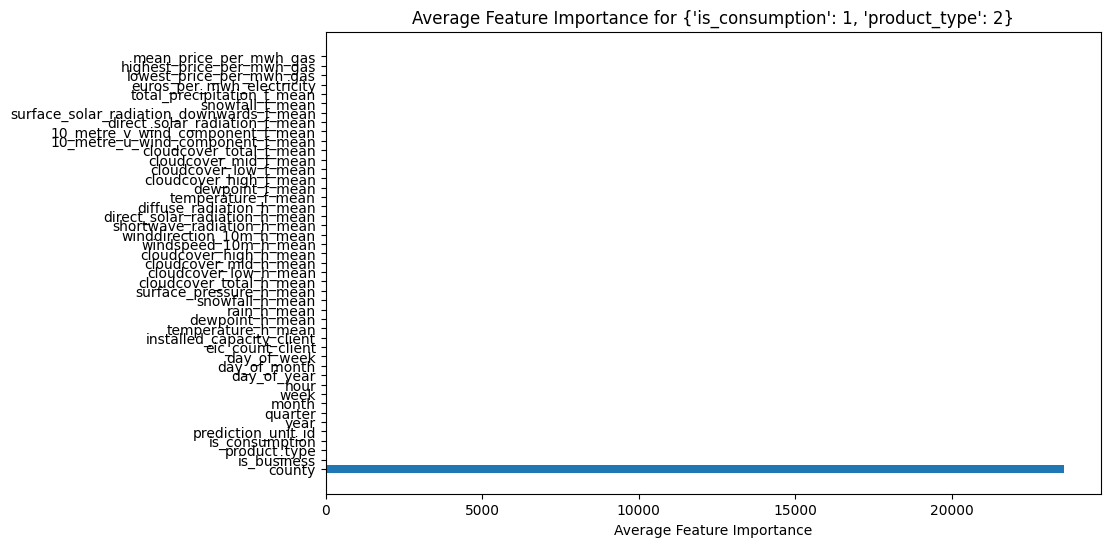

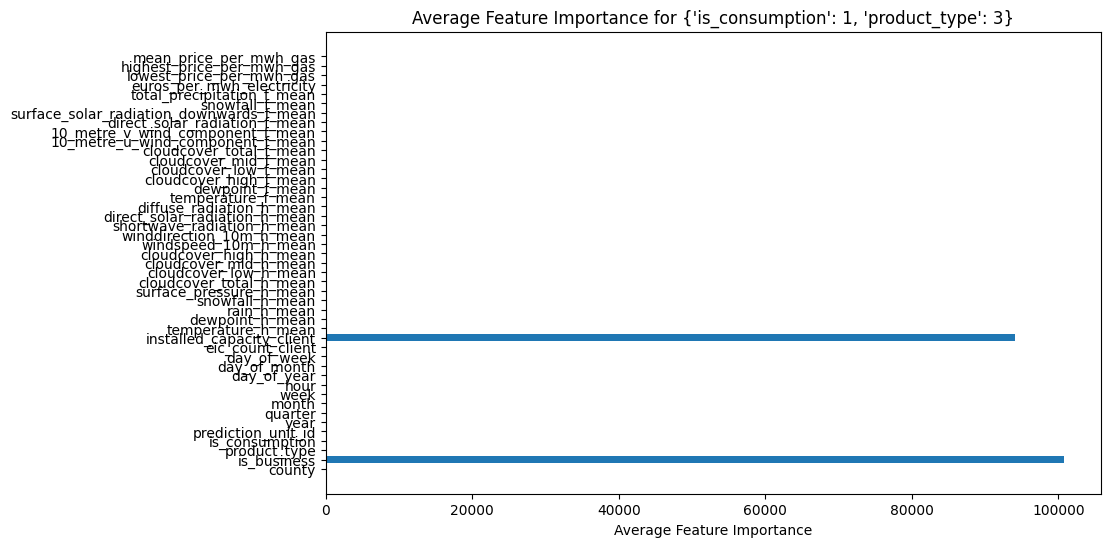

CPU times: user 5.73 s, sys: 127 ms, total: 5.86 s
Wall time: 1.99 s


In [ ]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

# model_dict = {'key1': [model1, model2, ...], 'key2': [model3, model4, ...], ...}

# 特徴重要度の平均を計算する関数
def average_feature_importances(models):
    # 特徴重要度を格納するための配列を初期化
    feature_importances = np.zeros_like(models[0].booster.feature_importance(importance_type="gain"))

    # 各モデルの特徴重要度を集計
    for model in models:
        feature_importances += model.booster.feature_importance(importance_type="gain")

    # 平均特徴重要度を計算
    return feature_importances / len(models)

# 各キーに対して平均特徴重要度を計算し、プロットする
for key, models in model_dict.items():
    # 平均特徴重要度の計算
    avg_importances = average_feature_importances(models)

    # 特徴名の取得
    feature_names = models[0].booster.feature_name()

    # 平均特徴重要度をプロット
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, avg_importances)
    plt.xlabel('Average Feature Importance')
    plt.title(f'Average Feature Importance for {models[0].description}')
    plt.show()


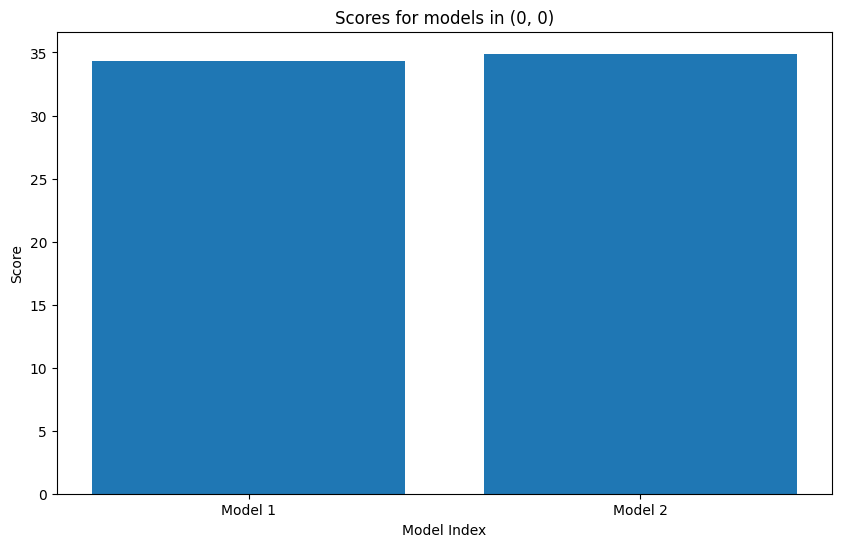

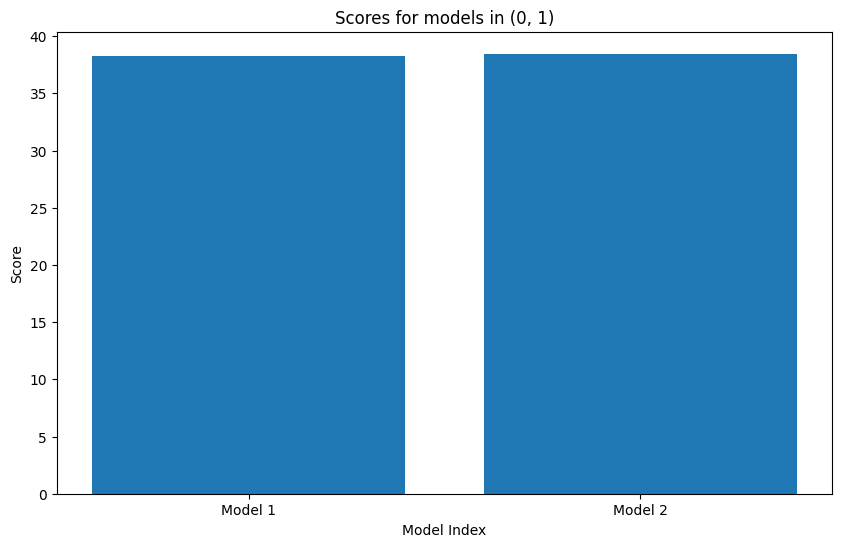

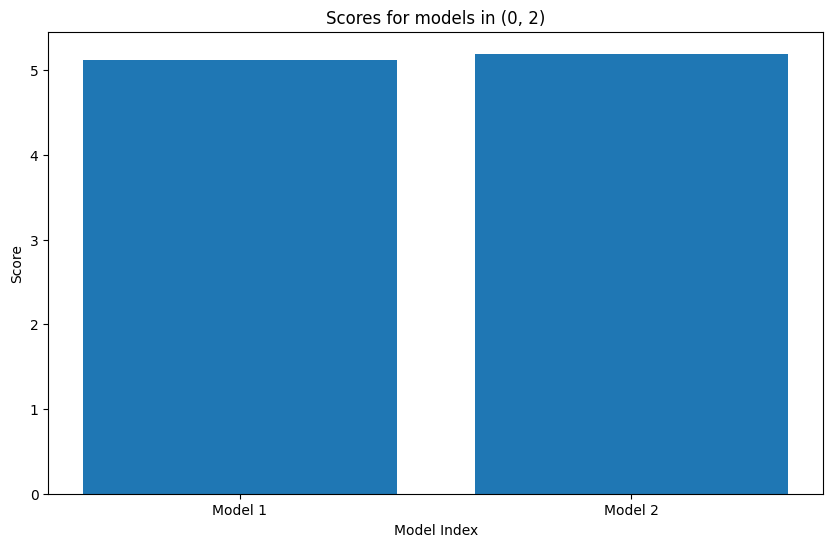

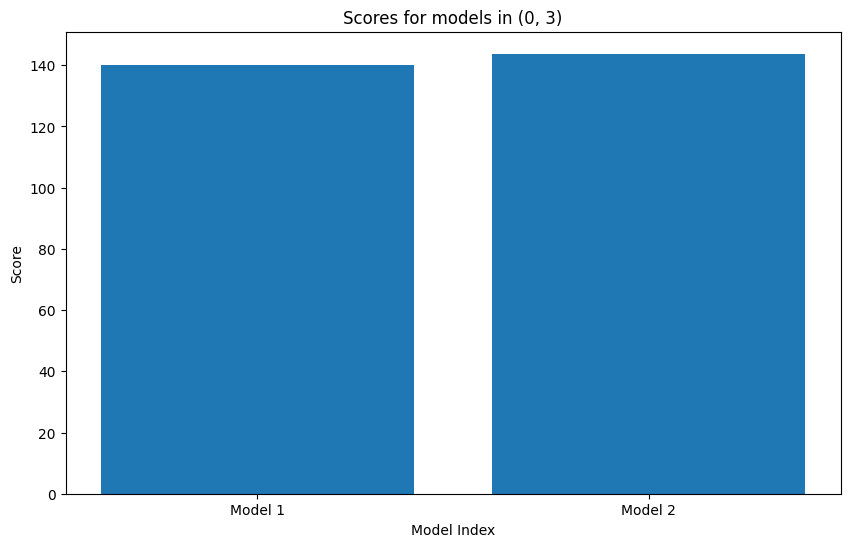

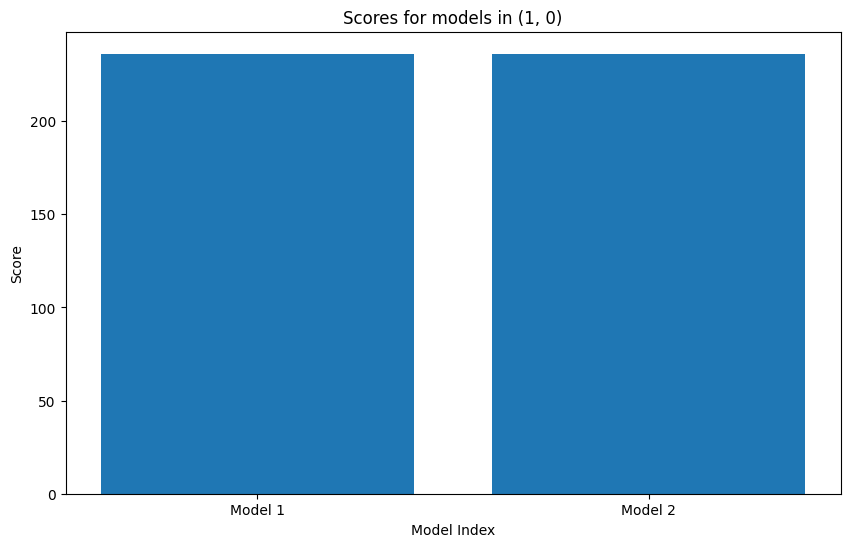

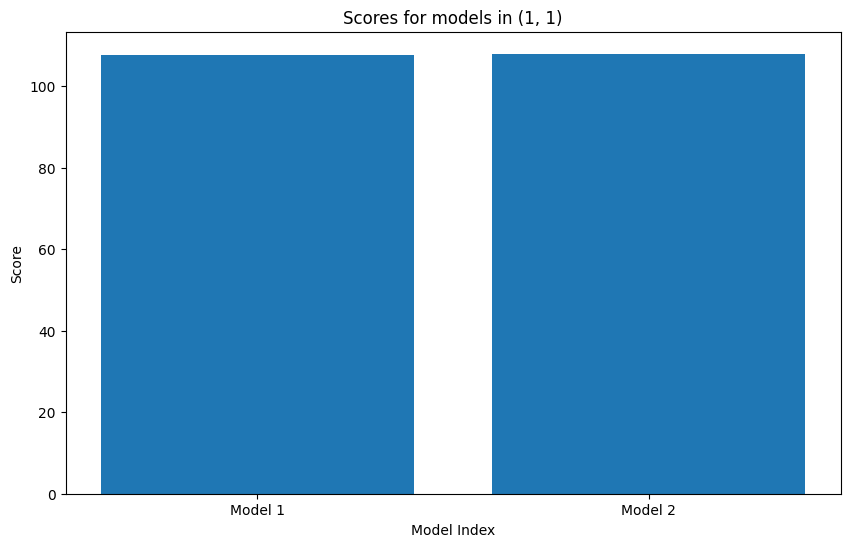

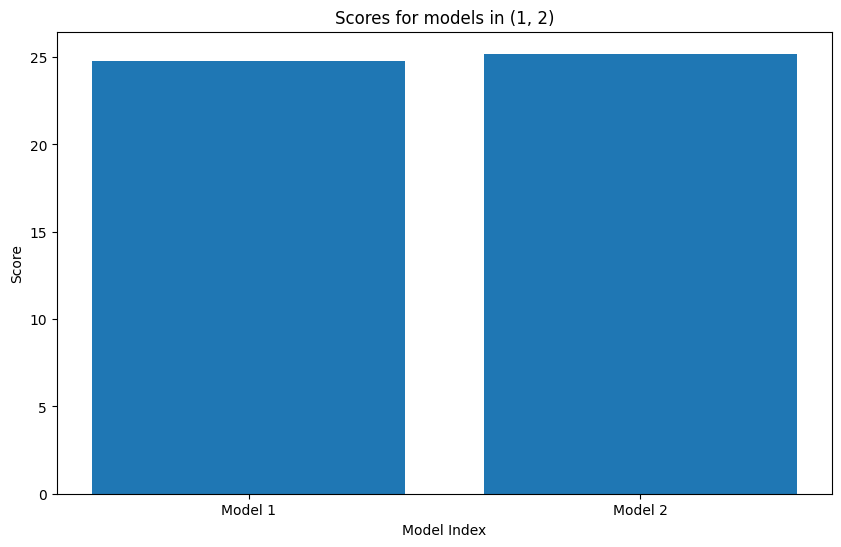

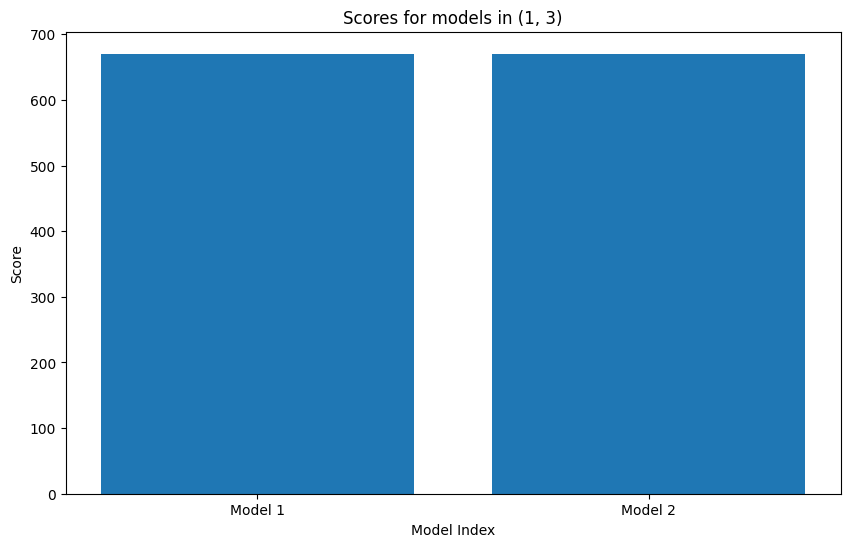

In [ ]:
import matplotlib.pyplot as plt

# model_dict = {'key1': [model1, model2, ...], 'key2': [model3, model4, ...], ...}

# 各キーに対してスコアをプロットする
for key, models in model_dict.items():
    # 各モデルのスコアを取得
    scores = [model.score for model in models]

    # スコアをプロット
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(scores)), scores)
    plt.xlabel('Model Index')
    plt.ylabel('Score')
    plt.title(f'Scores for models in {key}')
    plt.xticks(range(len(scores)), [f'Model {i+1}' for i in range(len(scores))])
    plt.show()


In [ ]:
# Clear memory
train_with_features_types = train_with_features.dtypes
# del train_with_features
collect()
GetMemUsage()

'RAM memory GB usage = 1.47'

# Predict and submit

In [ ]:
def create_revealed_targets_test(data, previous_revealed_targets, N_day_lags):
    '''🎯 Create new test data based on previous_revealed_targets and N_day_lags 🎯 ''' 
    for count, revealed_targets in enumerate(previous_revealed_targets) :
        day_lag = count + 2
        
        # Get hour
        revealed_targets['hour'] = pd.to_datetime(revealed_targets['datetime']).dt.hour
        
        # Select columns and rename target
        revealed_targets = revealed_targets[['hour', 'prediction_unit_id', 'is_consumption', 'target']]
        revealed_targets = revealed_targets.rename(columns = {"target" : f"target_{day_lag}_days_ago"})
        
        
        # Add past revealed targets
        data = pd.merge(data,
                        revealed_targets,
                        how = 'left',
                        on = ['hour', 'prediction_unit_id', 'is_consumption'],
                       )
        
    # If revealed_target_columns not available, replace by nan
    all_revealed_columns = [f"target_{day_lag}_days_ago" for day_lag in range(2, N_day_lags+1)]
    missing_columns = list(set(all_revealed_columns) - set(data.columns))
    data[missing_columns] = np.nan 
    
    return data

def format_test_with_features(test):
    if len(test.columns) != len(features):
        raise Exception("len(test.columns) != len(features.columns)")

    if set(test.columns) != set(features):
        raise Exception("Column names in test and check_test_with_features do not match")

    for column in test.columns:
        if test[column].dtype != train_with_features_types[column]:
            #print(f"{column}: test: {test[column].dtype} != train: {train_with_features_types[column]}")
            test[column] = test[column].astype(train_with_features_types[column])
            #raise Exception(f"Data type for column {column} differs between test and check_test_with_features")
    return test

In [ ]:
if IS_LOCAL or IS_DEBUG:
    print("Local submission")
    env = make_env()
else:
    print("Online Submission")
    import enefit
    env = enefit.make_env()
iter_test = env.iter_test()

# List of target_revealed dataframes
previous_revealed_targets = []
cache_preditcs = pd.DataFrame()

for (test, 
     revealed_targets, 
     client_test, 
     historical_weather_test,
     forecast_weather_test, 
     electricity_test, 
     gas_test, 
     sample_prediction) in iter_test:
    
    # Rename test set to make consistent with train
    test = test.rename(columns = {'prediction_datetime': 'datetime'})

    # Initiate column data_block_id with default value to join on
    id_column = 'data_block_id' 
    
    test[id_column] = 0
    gas_test[id_column] = 0
    electricity_test[id_column] = 0
    historical_weather_test[id_column] = 0
    forecast_weather_test[id_column] = 0
    client_test[id_column] = 0
    revealed_targets[id_column] = 0
    
    data_test = FeatureProcessor(
                               data = test,
                               client = client_test, 
                               historical_weather = historical_weather_test,
                               forecast_weather = forecast_weather_test, 
                               electricity = electricity_test, 
                               gas = gas_test
                               )
    
    # Store revealed_targets
    previous_revealed_targets.insert(0, revealed_targets)
    
    if len(previous_revealed_targets) == N_day_lags:
        previous_revealed_targets.pop()
    
    # Add previous revealed targets
    df_test = create_revealed_targets_test(data = data_test.copy(),
                                           previous_revealed_targets = previous_revealed_targets.copy(),
                                           N_day_lags = N_day_lags
                                          )
    
    # Make prediction
    X_test = df_test[features]
    X_test = format_test_with_features(X_test)

    # GROUP_KEYSによるグループ化、各グループに対して予測を行う
    predicts = X_test.groupby(GROUP_KEYS).apply(
        lambda group: pd.Series(np.mean([model.booster.predict(group[features]) for model in model_dict[group.name]], axis=0), index=group.index)
    )
    predicts = predicts.reset_index(level=GROUP_KEYS, drop=True)
    
    X_predict = X_test.join(predicts.rename('predicts'))
    X_predict = X_test.join(predicts)
    X_predict["predicts"] = X_predict["predicts"].astype("float32")
    if X_predict["predicts"].isnull().sum() > 0:
        raise Exception(f"Missing values in predicts: {X_predict['predicts'].isnull().sum()}")

    sample_prediction['target'] = X_predict["predicts"]
    if IS_DEBUG:
        df_preditcts = df_test.join(predicts.rename('predicts'))
        cache_preditcs = pd.concat([cache_preditcs, df_preditcts])
    env.predict(sample_prediction)

Local submission


FileNotFoundError: [Errno 2] No such file or directory: '../kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/test.csv'

In [ ]:
if IS_DEBUG:
    cache_preditcs.to_csv(f"{BASE_OUTPUT_PATH}/cache_preditcs.csv", index=False)